# :)
Script Name: CPSZ_2  
Author: Fatemeh Delavari  
Version: 1.0 (09/30/2024)  
Description: Performs graph analysis on an epileptic EEG containing complex partial seizure

In [76]:
import mne
import os
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from scipy.signal import hilbert, butter, filtfilt

In [77]:
# Specify the path to your EDF file
# 1
file_name = 'aaaaabnn_s002_t004.edf'
folder_path = 'C:/Users/Atena/Documents/tuh_eeg_edf_files'
file_path = os.path.join(folder_path, file_name)

# Read the EDF file
raw = mne.io.read_raw_edf(file_path, preload=True)

# Get basic information
print(raw.info)
print(raw.ch_names)

sampfreq = raw.info['sfreq']

# Extract signal data
data, times = raw[:]

print(f"Data shape: {data.shape}")
print(f"Times shape: {times.shape}")

Extracting EDF parameters from C:\Users\Atena\Documents\tuh_eeg_edf_files\aaaaabnn_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 121599  =      0.000 ...   303.998 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-REF, EEG C3-REF, ...
 chs: 128 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 200.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 128
 projs: []
 sfreq: 400.0 Hz
 subject_info: 3 items (dict)
>
['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF', 'EEG EKG-REF', 'EEG 21-REF', 'EEG 22-REF', 'EEG T1-REF', 'EEG T2-REF', 'EEG 25-REF', 'EEG 26-REF', 'EEG 27-REF', 'EEG 28-REF', 'EEG 29-REF', 'EEG 30-REF', 'EEG 31-REF', 'EEG 32-REF', 'EEG 33-

In [78]:
# Define the channels you want to select
selected_channels = ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F7-REF', 'EEG F3-REF', 
                     'EEG FZ-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG T3-REF', 
                     'EEG C3-REF', 'EEG CZ-REF', 'EEG C4-REF', 'EEG T4-REF', 
                     'EEG T5-REF', 'EEG P3-REF', 'EEG PZ-REF', 'EEG P4-REF',
                     'EEG T6-REF', 'EEG O1-REF', 'EEG O2-REF']

raw_selected = raw.copy()
# Select the specified channels
raw_selected = raw_selected.pick_channels(selected_channels)

# Extract signal data for the selected channels
data, times = raw_selected[:]

print(f"Selected channels: {raw_selected.ch_names}")
print(f"Data shape: {data.shape}")
print(f"Times shape: {times.shape}")

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Selected channels: ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F7-REF', 'EEG F3-REF', 'EEG FZ-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG C3-REF', 'EEG CZ-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG P3-REF', 'EEG PZ-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O1-REF', 'EEG O2-REF']
Data shape: (19, 121600)
Times shape: (121600,)


In [94]:
simplified_names = [
    'FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4',
    'T5', 'T6', 'FZ', 'CZ', 'PZ'
]

In [96]:
# Define the seizure and background time intervals (in seconds)
seizure_start, seizure_end = 45, 181 
background_start_1, background_end_1 = 0, 44
background_start_2, background_end_2 = 182, 303

In [150]:
# Filter the channels that include 'eog' (case-insensitive)
ecg_channels = [ch for ch in raw.ch_names if 'ekg' in ch.lower() or 'ecg' in ch.lower()]

if len(ecg_channels) > 0:
    # Copy raw and pick only the EOG channels
    raw_selected_ecg = raw.copy().pick_channels(ecg_channels)
    print(f"ECG channels: {raw_selected_ecg.ch_names}")
else:
    # Create an empty raw object if no EOG channels are found
    raw_selected_ecg = None
    print("No ECG channels found.")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
ECG channels: ['EEG EKG-REF']


In [80]:
# Filter the channels that include 'eog' (case-insensitive)
eog_channels = [ch for ch in raw.ch_names if 'eog' in ch.lower()]

if len(eog_channels) > 0:
    # Copy raw and pick only the EOG channels
    raw_selected_eog = raw.copy().pick_channels(eog_channels)
    print(f"EOG channels: {raw_selected_eog.ch_names}")
else:
    # Create an empty raw object if no EOG channels are found
    raw_selected_eog = None
    print("No EOG channels found.")


No EOG channels found.


In [6]:
# from sklearn.linear_model import LinearRegression

# # Get the data for regression (EEG, EOG, ECG)
# eeg_data, time = raw_selected[:]

# # Check if raw_selected_ecg is None
# if raw_selected_ecg is not None:
#     ecg_data, time = raw_selected_ecg[:]
# else:
#     ecg_data = None  # Set ecg_data to None if there are no ECG channels

# # Check if raw_selected_ecg is None
# if raw_selected_eog is not None:
#     eog_data, time = raw_selected_eog[:]
# else:
#     eog_data = None  # Set ecg_data to None if there are no ECG channels

# # Perform linear regression for each EEG channel
# cleaned_eeg_data = np.copy(eeg_data)

# for i in range(eeg_data.shape[0]):
#     # Combine EOG data with ECG data if available, otherwise use only EOG
#     if ecg_data is not None and eog_data is not None:
#         regressors = np.vstack([eog_data, ecg_data]).T  # Use both EOG and ECG as regressors
#     elif ecg_data is not None and eog_data is None:
#         regressors = np.vstack([ecg_data]).T  
#     elif eog_data is not None and ecg_data is None:
#         regressors = np.vstack([eog_data]).T  
#     else:
#         regressors = None
    
#     # Fit regression model
#     model = LinearRegression()
#     model.fit(regressors, eeg_data[i])
    
#     # Predict the artifact and subtract it from the original signal
#     artifact = model.predict(regressors)
#     cleaned_eeg_data[i] = eeg_data[i] - artifact

# # Now cleaned_eeg_data contains the EEG data with artifacts removed


In [7]:
# raw_cleaned = raw_selected.copy()
# # Replace the data in raw_selected with the cleaned data
# raw_cleaned._data[:] = cleaned_eeg_data

In [8]:
# # Verify the data has been replaced
# print(raw_selected._data[:])

In [9]:
# # Verify the data has been replaced
# print(raw_cleaned._data[:])

In [81]:
raw_cleaned = raw_selected.copy()

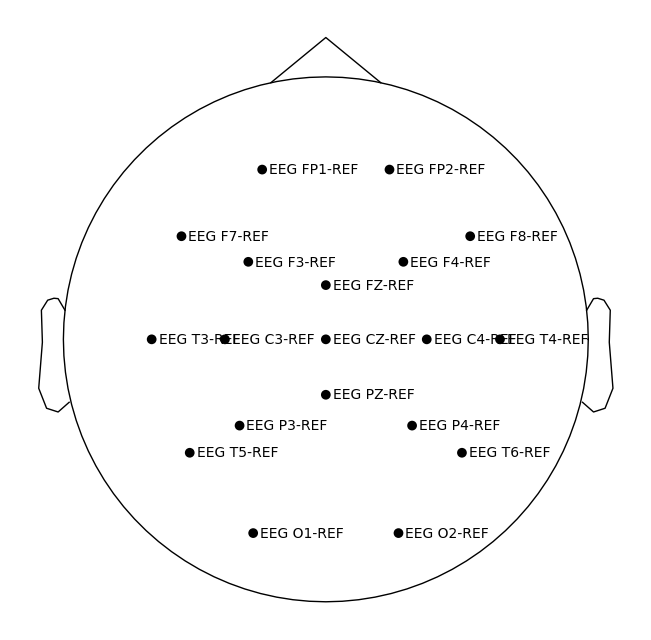

In [84]:
# Define positions (in meters) for the channels

pos = {'FP1': (-0.03, 0.08, 0.05),
'FP2': (0.03, 0.08, 0.05),
'F3': (-0.04, 0.04, 0.06),
'F4': (0.04, 0.04, 0.06),
'C3': (-0.05, 0.00, 0.04),
'C4': (0.05, 0.00, 0.04),
'P3': (-0.04, -0.04, 0.03),
'P4': (0.04, -0.04, 0.03),
'O1': (-0.03, -0.08, 0.02),
'O2': (0.03, -0.08, 0.02),
'F7': (-0.07, 0.05, 0.06),
'F8': (0.07, 0.05, 0.06),
'T3': (-0.08, 0.00, 0.04),
'T4': (0.08, 0.00, 0.04),
'T5': (-0.06, -0.05, 0.03),
'T6': (0.06, -0.05, 0.03),
'FZ': (0.00, 0.03, 0.07),
'CZ': (0.00, 0.00, 0.06),
'PZ': (0.00, -0.03, 0.05)}

# Convert positions to a format compatible with MNE
montage_positions = {ch_name: np.array(pos[ch_name.replace('EEG ', '').replace('-REF', '')])
                     for ch_name in selected_channels}


# Create a custom montage
montage = mne.channels.make_dig_montage(ch_pos=montage_positions, coord_frame='head')

# Apply the montage to the raw data
raw_cleaned.set_montage(montage)

plt.close('all')
# Plot to verify that electrode locations are now added
raw_cleaned.plot_sensors(show_names=True)

plt.close('all')

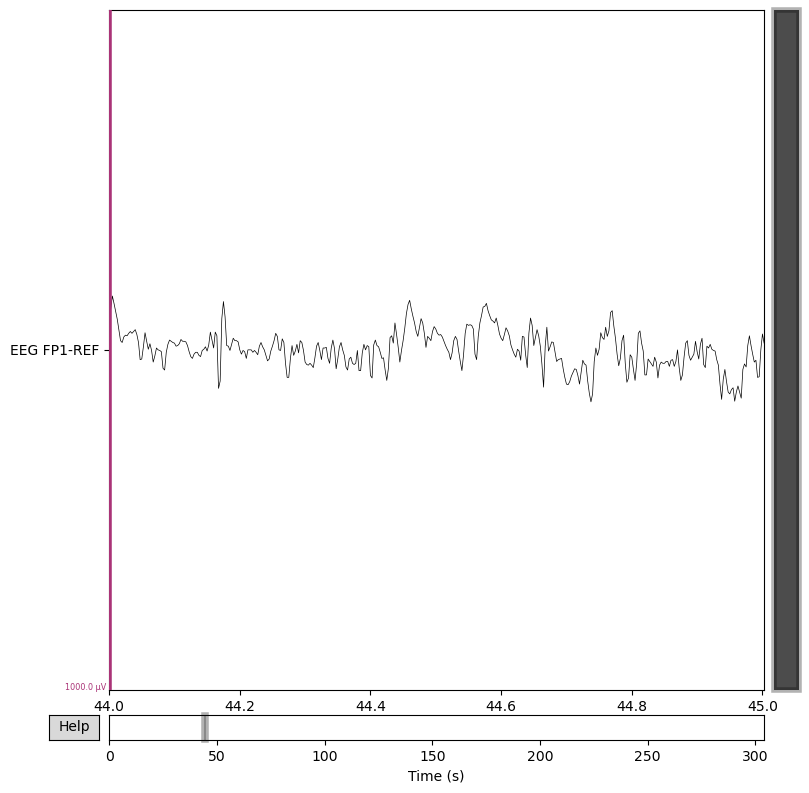

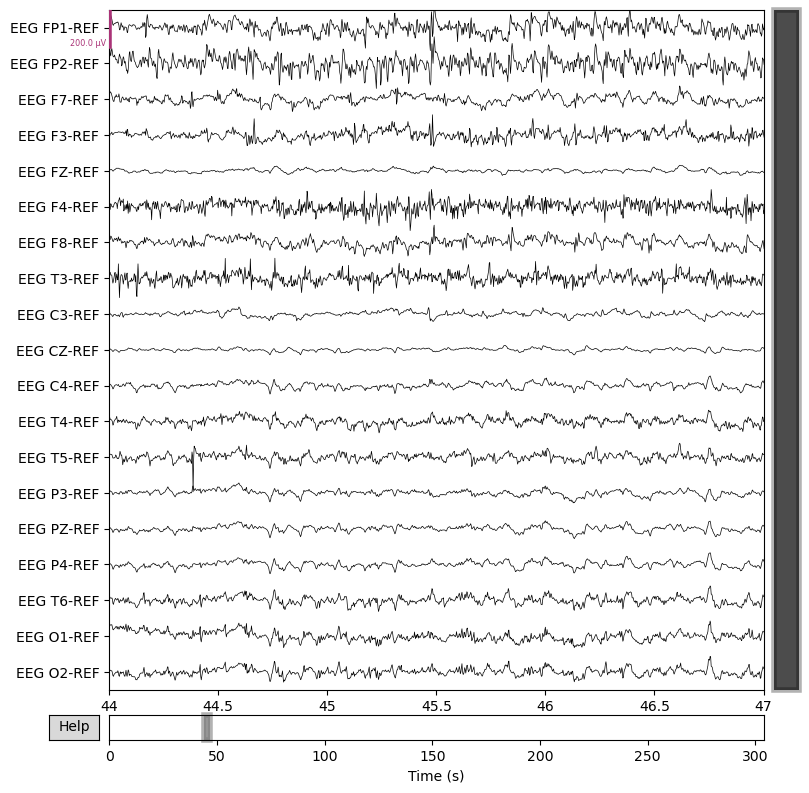

In [85]:
# Define the specific channels you want to plot
channels_to_plot = ['EEG FP1-REF']

# Close all previous figures
plt.close('all')
# Plot the specific channels
raw_selected.plot(
    picks=channels_to_plot,  # Specify the channels to plot
    duration=1,
    start=44,
    scalings= {'eeg': 5*10e-5},
    title='Raw EEG Data - Specific Channels',
    show=True,
    block=False
)

# Close all previous figures
plt.close('all')
raw_selected.plot(
    n_channels=19,
    duration=3,
    start=44,
    scalings= {'eeg': 10e-5},
    title='Raw EEG Data',
    show=True,
    block=False
)

plt.close('all')

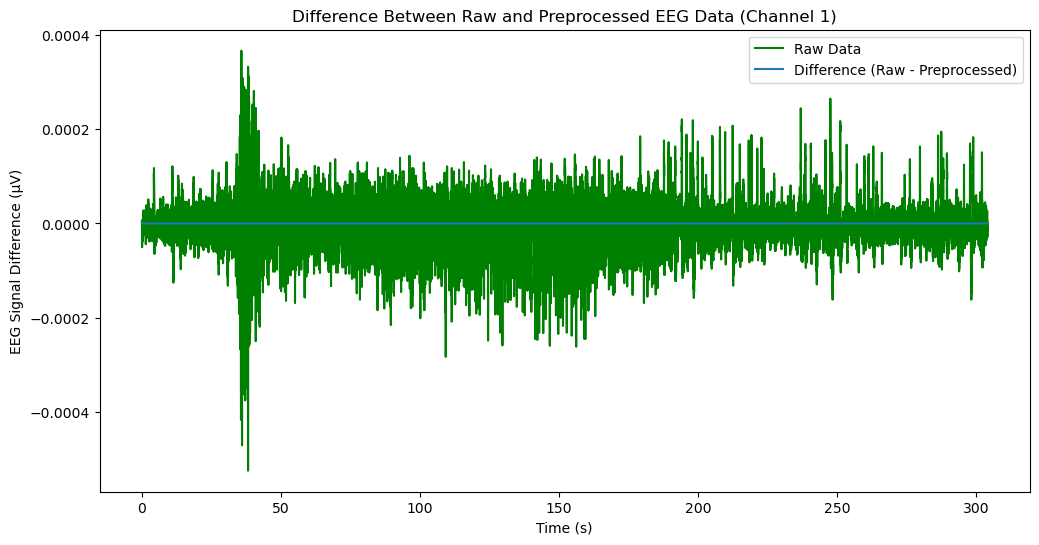

In [14]:
strt=44
sampfreq = int(sampfreq)
# Extract data and times
# raw_data, raw_times = raw_selected[:, strt*sampfreq:(strt+1)*sampfreq]  # raw EEG data and times
# preprocessed_data, _ = raw_cleaned[:, strt*sampfreq:(strt+1)*sampfreq]  # preprocessed EEG data

raw_data, raw_times = raw_selected[:]  # raw EEG data and times
preprocessed_data, _ = raw_cleaned[:]  # preprocessed EEG data

# Compute the difference
data_diff = raw_data - preprocessed_data

# Close all previous figures
plt.close('all')

# Plot the difference for a specific channel (e.g., channel 0)
channel_idx = 0  # index of the channel you want to plot
plt.figure(figsize=(12, 6))
# You can keep adding more plots on the same figure this way
plt.plot(raw_times, raw_data[channel_idx, :], label='Raw Data', color='green')
plt.plot(raw_times, data_diff[channel_idx, :], label='Difference (Raw - Preprocessed)')
plt.xlabel('Time (s)')
plt.ylabel('EEG Signal Difference (µV)')
plt.title(f'Difference Between Raw and Preprocessed EEG Data (Channel {channel_idx+1})')
plt.legend()
plt.show()

In [15]:
preprocEEG = raw_cleaned.copy()

# Define the Butterworth filter parameters with filtfilt applied
iir_params = dict(order=6, ftype='butter', output='sos')

# Band-pass filter the data using a 6th-order Butterworth filter with filtfilt applied
preprocEEG.filter(l_freq=1.0, h_freq=40, method='iir', iir_params=iir_params, phase='zero')

# Notch filter to remove power line noise (assuming 60 Hz)
preprocEEG.notch_filter(freqs=60.0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters


---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 2641 samples (6.603 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished


Measurement date,"January 01, 2000 00:00:00 GMT"
Experimenter,Unknown
Participant,aaaaabnn
Digitized points,22 points
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,400.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [16]:
# Plot the specific channels
# preprocEEG.plot(
#     picks=channels_to_plot,  # Specify the channels to plot
#     duration=1,
#     start=44,
#     scalings= {'eeg': 5*10e-5},
#     title='Raw EEG Data - Specific Channels',
#     show=False,
#     block=False
# )

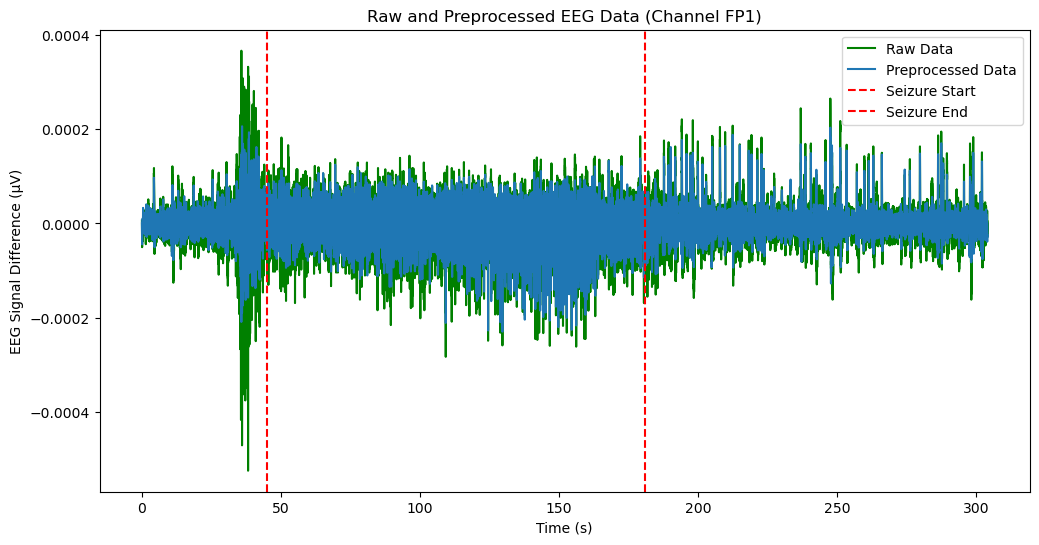

In [99]:
preprocEEG_data, preprocEEG_times = preprocEEG[:]  # raw EEG data and times

# Plot the difference for a specific channel (e.g., channel 0)
channel_idx = 0  # index of the channel you want to plot
plt.figure(figsize=(12, 6))
# You can keep adding more plots on the same figure this way
plt.plot(raw_times, raw_data[channel_idx, :], label='Raw Data', color='green')
plt.plot(raw_times, preprocEEG_data[channel_idx, :], label='Preprocessed Data')
plt.axvline(x=seizure_start, color='red', linestyle='--', label='Seizure Start')  # Adjusted for the new x-values
plt.axvline(x=seizure_end, color='red', linestyle='--', label='Seizure End')    # Adjusted for the new x-values
plt.xlabel('Time (s)')
plt.ylabel('EEG Signal Difference (µV)')
plt.title(f'Raw and Preprocessed EEG Data (Channel {simplified_names[channel_idx]})')
plt.legend()
plt.show()

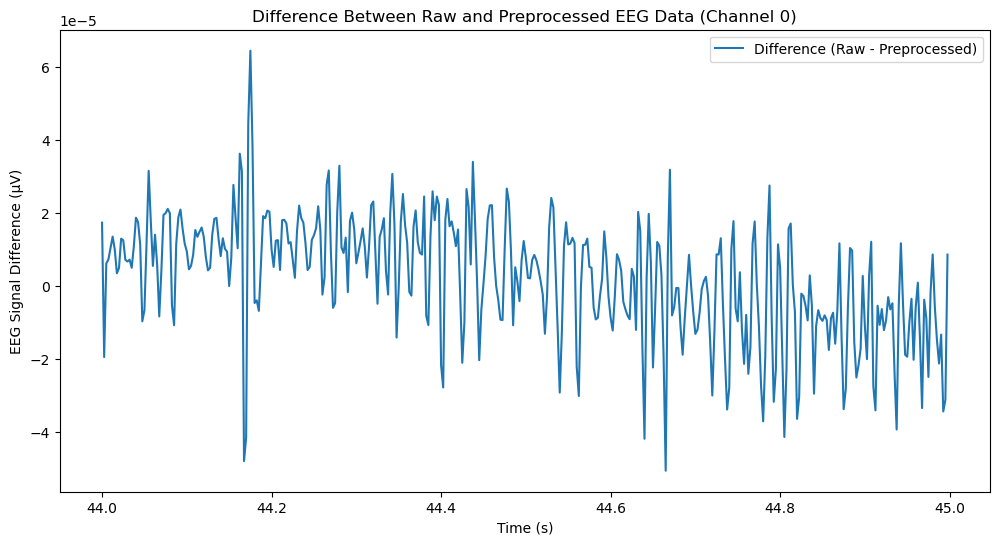

In [18]:
strt=44
sampfreq = int(sampfreq)
# Extract data and times
raw_data, raw_times = raw_selected[:, strt*sampfreq:(strt+1)*sampfreq]  # raw EEG data and times
preprocessed_data, _ = preprocEEG[:, strt*sampfreq:(strt+1)*sampfreq]  # preprocessed EEG data

# Compute the difference
data_diff = raw_data - preprocessed_data

# Close all previous figures
plt.close('all')

# Plot the difference for a specific channel (e.g., channel 0)
channel_idx = 0  # index of the channel you want to plot
plt.figure(figsize=(12, 6))
plt.plot(raw_times, data_diff[channel_idx, :], label='Difference (Raw - Preprocessed)')
plt.xlabel('Time (s)')
plt.ylabel('EEG Signal Difference (µV)')
plt.title(f'Difference Between Raw and Preprocessed EEG Data (Channel {channel_idx})')
plt.legend()
plt.show()

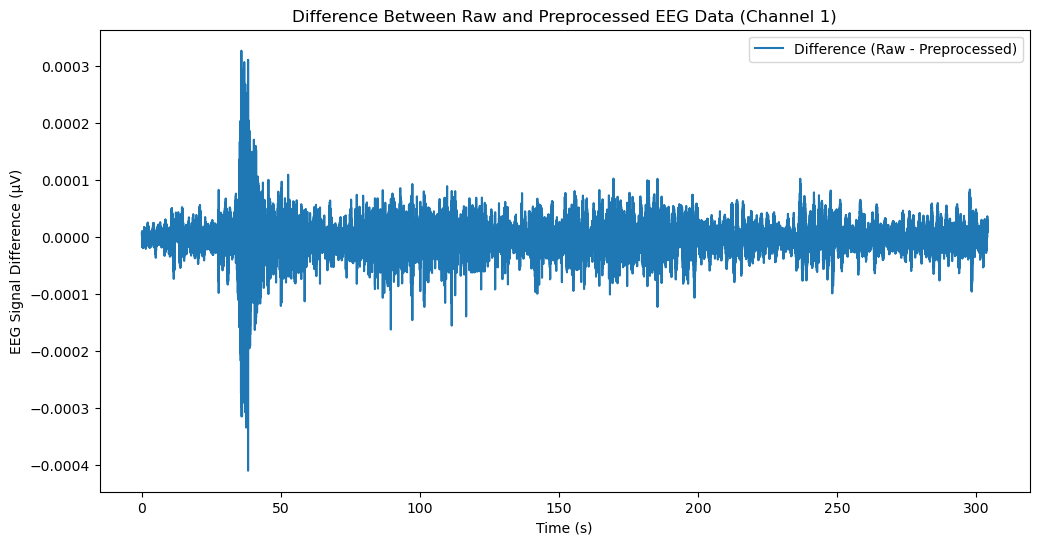

In [90]:
# Extract data and times
raw_data, raw_times = raw_selected[:]  # raw EEG data and times
preprocessed_data, _ = preprocEEG[:]  # preprocessed EEG data

# Compute the difference
data_diff = raw_data - preprocessed_data

# Close all previous figures
plt.close('all')

# Plot the difference for a specific channel (e.g., channel 0)
channel_idx = 0  # index of the channel you want to plot
plt.figure(figsize=(12, 6))
plt.plot(raw_times, data_diff[channel_idx, :], label='Difference (Raw - Preprocessed)')
plt.xlabel('Time (s)')
plt.ylabel('EEG Signal Difference (µV)')
plt.title(f'Difference Between Raw and Preprocessed EEG Data (Channel {channel_idx+1})')
plt.legend()
plt.show()

In [20]:
eegICA = preprocEEG.copy()
from mne.preprocessing import ICA

# Set up the ICA object, specifying the number of components to compute
ica = ICA(n_components=19, random_state=97, max_iter=1000)

# Fit ICA to the raw data
ica.fit(eegICA)


Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components
Fitting ICA took 1.5s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,34 iterations on raw data (121600 samples)
ICA components,19
Available PCA components,19
Channel types,eeg
ICA components marked for exclusion,—


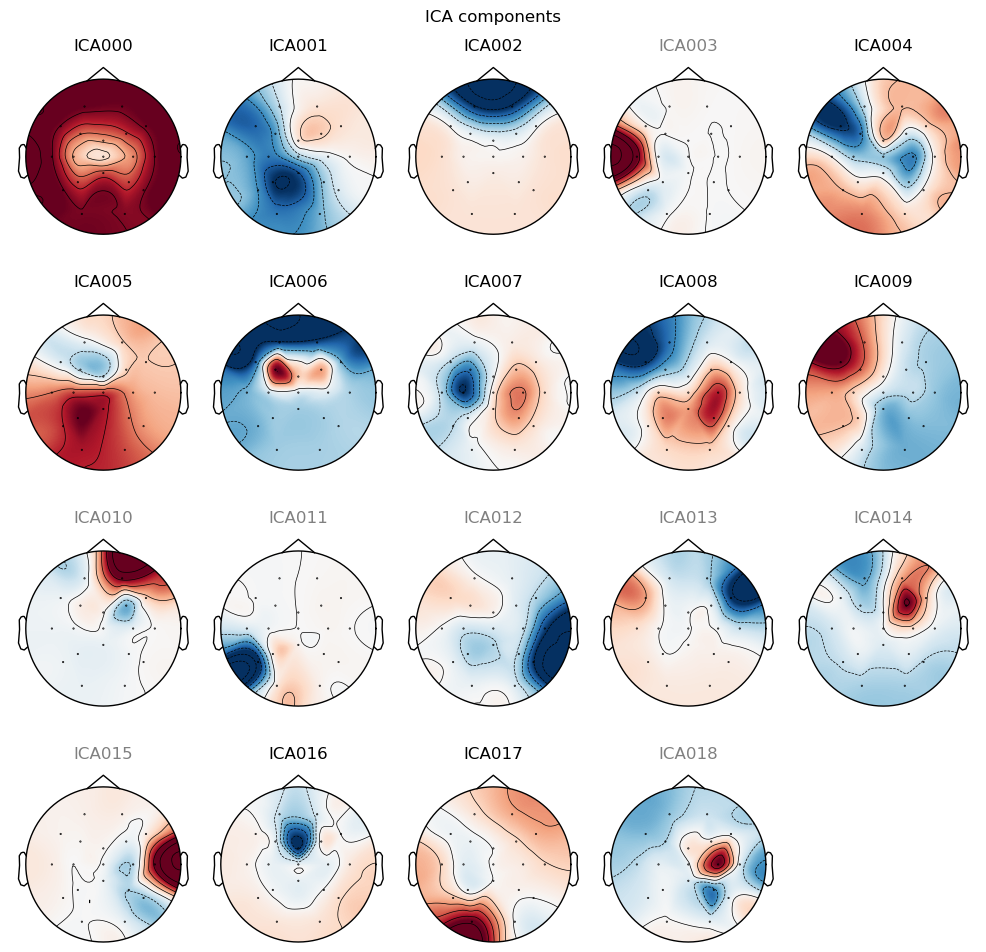

In [88]:
# Plot ICA components to manually inspect them
ica.plot_components()
plt.close('all')

In [22]:
emg_inds, scores = ica.find_bads_muscle(eegICA)
ica.exclude.extend(emg_inds)

Effective window size : 5.120 (s)


In [23]:
ica

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,34 iterations on raw data (121600 samples)
ICA components,19
Available PCA components,19
Channel types,eeg
ICA components marked for exclusion,ICA003ICA010ICA011ICA012ICA013ICA014ICA015ICA018


In [24]:
# Apply the ICA to the raw data
ica.apply(eegICA)

Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 8 ICA components
    Projecting back using 19 PCA components


Measurement date,"January 01, 2000 00:00:00 GMT"
Experimenter,Unknown
Participant,aaaaabnn
Digitized points,22 points
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,400.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [25]:
eegICA.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Measurement date,"January 01, 2000 00:00:00 GMT"
Experimenter,Unknown
Participant,aaaaabnn
Digitized points,22 points
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,400.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


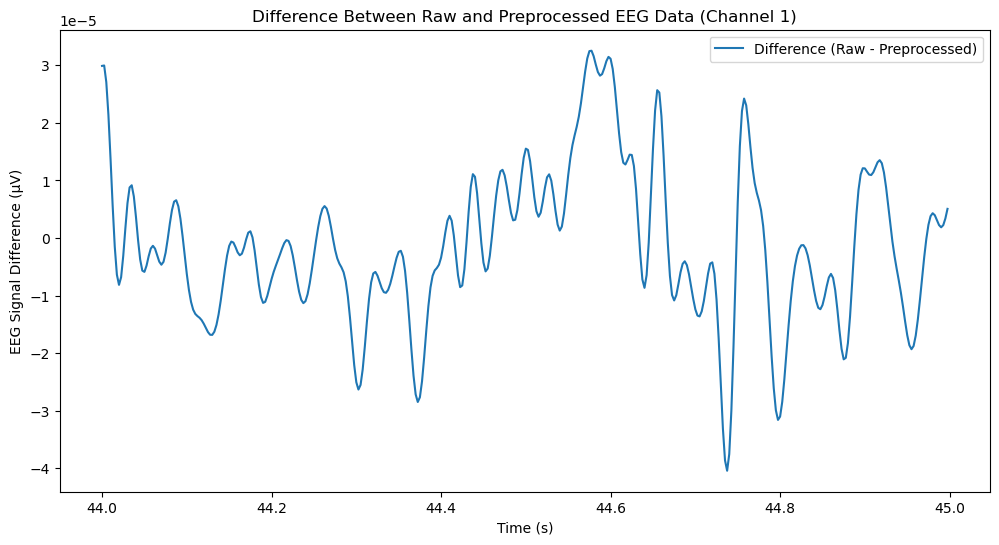

In [89]:
strt=44
sampfreq = int(sampfreq)
# Extract data and times
eegICA_data, eeg_times = eegICA[:, strt*sampfreq:(strt+1)*sampfreq]  # raw EEG data and times
preprocessed_data, _ = preprocEEG[:, strt*sampfreq:(strt+1)*sampfreq]  # preprocessed EEG data

# Compute the difference
data_diff = preprocessed_data - eegICA_data

# Close all previous figures
plt.close('all')

# Plot the difference for a specific channel (e.g., channel 0)
channel_idx = 0  # index of the channel you want to plot
plt.figure(figsize=(12, 6))
plt.plot(eeg_times, data_diff[channel_idx, :], label='Difference (Raw - Preprocessed)')
plt.xlabel('Time (s)')
plt.ylabel('EEG Signal Difference (µV)')
plt.title(f'Difference Between Raw and Preprocessed EEG Data (Channel {channel_idx+1})')
plt.legend()
plt.show()

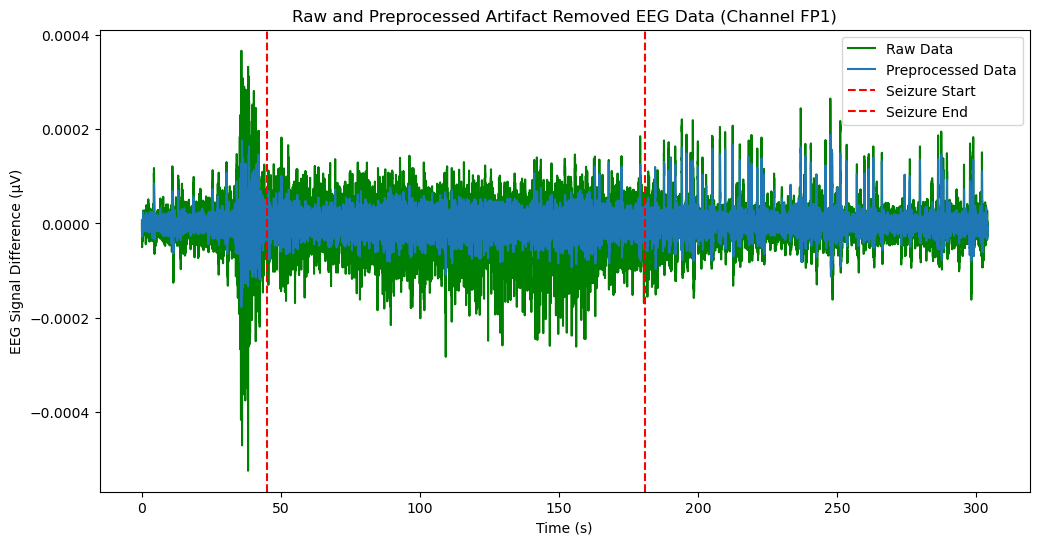

In [153]:
eegICA_data, eeg_times = eegICA[:,:]
# Comparison between raw and preprocessed artifact removed EEG
channel_idx = 0  # index of the channel you want to plot
plt.figure(figsize=(12, 6))
# You can keep adding more plots on the same figure this way
plt.plot(raw_times, raw_data[channel_idx, :], label='Raw Data', color='green')
plt.plot(raw_times, eegICA_data[channel_idx, :], label='Preprocessed Data')
plt.axvline(x=seizure_start, color='red', linestyle='--', label='Seizure Start')  # Adjusted for the new x-values
plt.axvline(x=seizure_end, color='red', linestyle='--', label='Seizure End')    # Adjusted for the new x-values
plt.xlabel('Time (s)')
plt.ylabel('EEG Signal Difference (µV)')
plt.title(f'Raw and Preprocessed Artifact Removed EEG Data (Channel {simplified_names[channel_idx]})')
plt.legend()
plt.show()

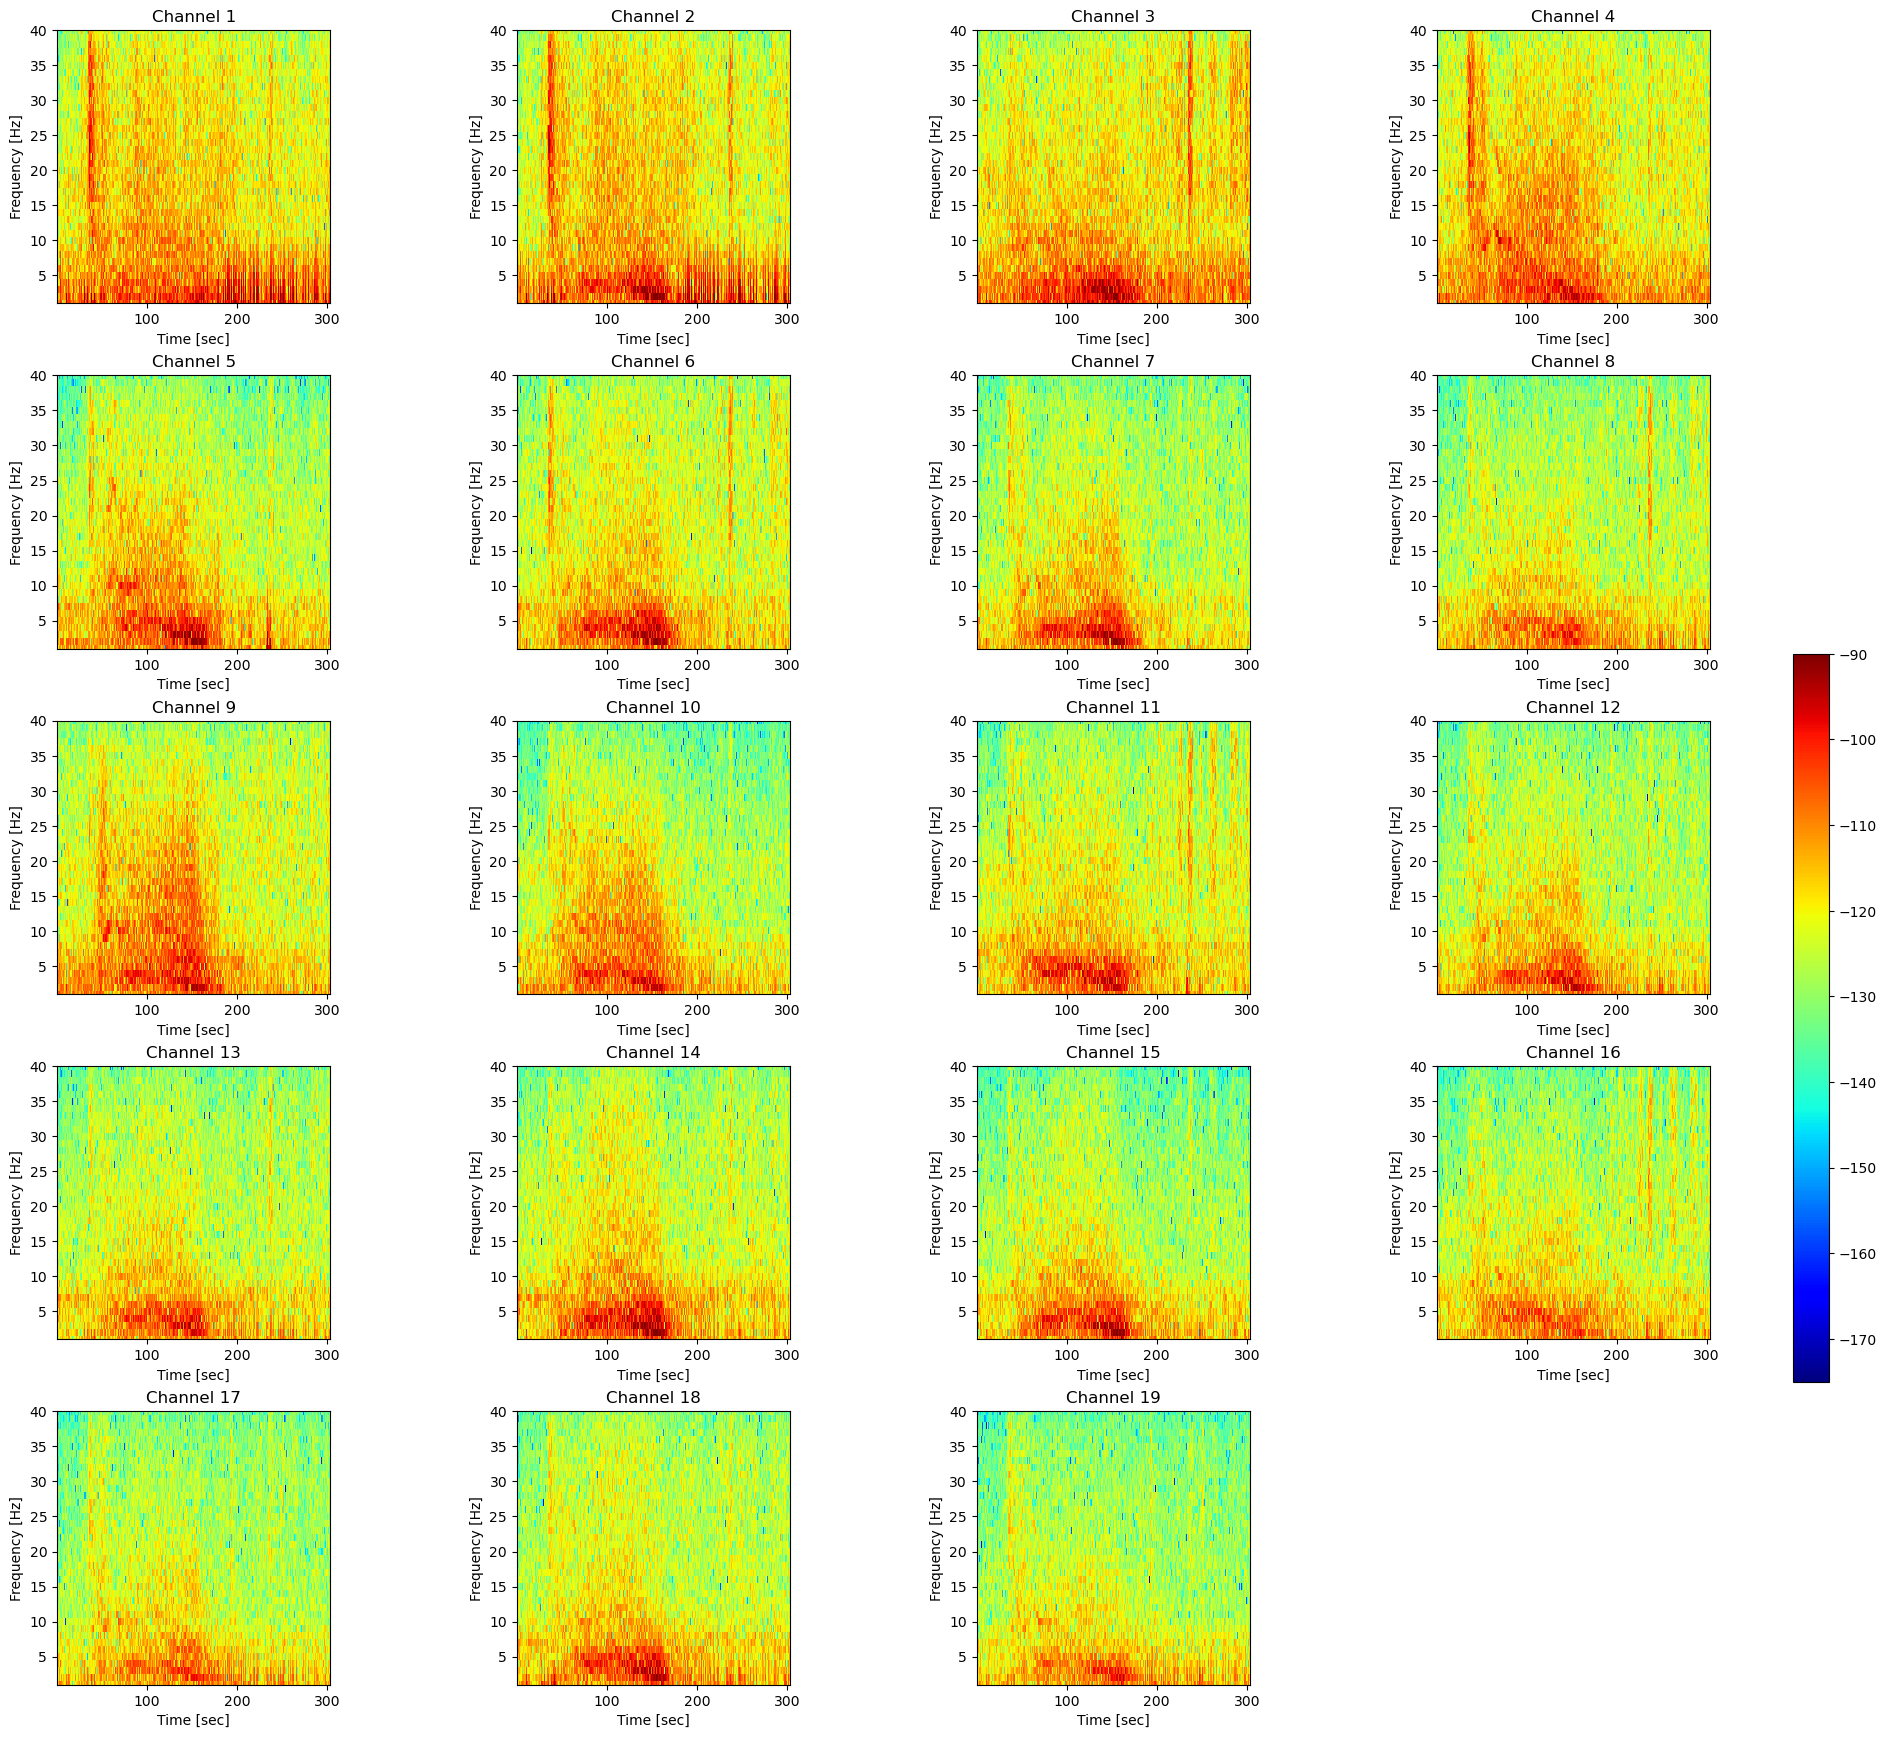

In [101]:
from scipy.signal import spectrogram

channel_index = 1
# Generate a sample signal (sine wave with two frequencies)
fs = sampfreq  # Sampling frequency (Hz)
# Extract signal data
data, times = eegICA[:, :]
signal = data[channel_index, :]

# Parameters for the spectrogram
nperseg = fs  # Length of each segment (window length)
noverlap = fs//2  # Number of points to overlap between segments

nrows = 6
ncols = 4

num_channels = 19
# Create subplots for all channels
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20), constrained_layout=True)
axes = axes.flatten()  # Flatten the axes for easier indexing

for i in range(num_channels):
    # Generate the spectrogram for each channel
    frequencies, times, Sxx = spectrogram(data[i],  fs, nperseg=nperseg, noverlap=noverlap)
    
    # Plot spectrogram for each channel
    img = axes[i].pcolormesh(times, frequencies, 10 * np.log10(Sxx), cmap = 'jet')

    # Set color limits
    img.set_clim(-175, -90)

    axes[i].set_title(f'Channel {i+1}')
    axes[i].set_ylabel('Frequency [Hz]')
    axes[i].set_xlabel('Time [sec]')
    axes[i].set_ylim(1, 40)  # Adjust based on your frequency range of interest
    axes[i].set_box_aspect(1)  # equivalent of 'Box' being 'on'

# Hide unused subplots if there are fewer channels than subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.colorbar(axes[0].collections[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()


In [28]:
def bandpass_filter(data, sfreq, low_freq, high_freq):
    """
    Band-pass filter the data.
    
    Parameters:
    data (ndarray): The input signal of shape (n_channels, n_times)
    sfreq (float): The sampling frequency
    low_freq (float): The lower bound of the frequency range
    high_freq (float): The upper bound of the frequency range
    
    Returns:
    filtered_data (ndarray): The band-pass filtered signal
    """
    nyquist = 0.5 * sfreq
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data

In [29]:
# Band pass filtering and phase calculation
eeg_data, _ = eegICA[:]
low_freq = 4
high_freq = 8

# low_freq = 1
# high_freq = 4

# low_freq = 8
# high_freq = 13

# low_freq = 13
# high_freq = 30

# low_freq = 30
# high_freq = 50

# Band-pass filter the data in the specified frequency band
eeg_data_filtered = bandpass_filter(eeg_data, sampfreq, low_freq, high_freq)
    
# Compute the analytic signal (Hilbert transform) to get the phase
analytic_signal = hilbert(eeg_data_filtered, axis=1)
phase_data = np.angle(analytic_signal)

In [30]:
eeg_data.shape

(19, 121600)

In [31]:
# Define the seizure and background time intervals (in seconds)
seizure_start, seizure_end = 45, 181 
background_start_1, background_end_1 = 0, 44
background_start_2, background_end_2 = 182, 303


# Extract seizure and background epochs
seizure_Seg = eegICA.copy().crop(tmin=seizure_start, tmax=seizure_end)
background_Seg_1 = eegICA.copy().crop(tmin=background_start_1, tmax=background_end_1)
background_Seg_2 = eegICA.copy().crop(tmin=background_start_2, tmax=background_end_2)

# If you need to combine the two background segments into one:
background_Seg = mne.concatenate_raws([background_Seg_1.copy(), background_Seg_2.copy()])

In [32]:
seizure_phase_Seg = phase_data.copy()[:, seizure_start*sampfreq:seizure_end*sampfreq]
back_phase_Seg = np.concatenate((phase_data.copy()[:, background_start_1*sampfreq:background_end_1*sampfreq], phase_data.copy()[:, background_start_2*sampfreq:background_end_2*sampfreq]), axis = 1)
print(seizure_phase_Seg.shape)
print(back_phase_Seg.shape)

(19, 54400)
(19, 66000)


In [33]:
# Parameters
epoch_length = 1  # in seconds
epoch_samples = int(epoch_length * sampfreq)

def epoch_data(data, sfreq, epoch_length):
    n_channels, n_samples = data.shape
    epoch_samples = int(epoch_length * sfreq)
    n_epochs = n_samples // epoch_samples
    epochs = np.array_split(data[:, :n_epochs * epoch_samples], n_epochs, axis=1)
    return epochs, n_epochs

# Epoch the seizure_Seg and background_Seg
seizure_epochs = epoch_data(seizure_Seg[:][0][:19], sampfreq, epoch_length)
background_epochs = epoch_data(background_Seg[:][0][:19], sampfreq, epoch_length)

seizure_phase_epochs, n_seizure_epochs  = epoch_data(seizure_phase_Seg[:19, :], sampfreq, epoch_length)
background_phase_epochs, n_background_epochs  = epoch_data(back_phase_Seg[:19, :], sampfreq, epoch_length)

In [34]:
def calculate_plv(phasedata):
    """
    Calculate the Phase Locking Value (PLV) between pairs of EEG channels.
    
    Parameters:
    eeg_data (ndarray): EEG data of shape (n_channels, n_times)
    sfreq (float): Sampling frequency of the EEG data
    low_freq (float): Lower frequency bound for band-pass filter (default 8 Hz)
    high_freq (float): Upper frequency bound for band-pass filter (default 13 Hz)
    
    Returns:
    plv_matrix (ndarray): PLV matrix of shape (n_channels, n_channels)
    """
    n_channels, n_times = phasedata.shape
    plv_matrix = np.zeros((n_channels, n_channels))
    
    # Calculate PLV
    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            phase_diff = phasedata[i] - phasedata[j]
            plv = np.abs(np.sum(np.exp(1j * phase_diff)) / n_times)
            plv_matrix[i, j] = plv
            plv_matrix[j, i] = plv  # PLV is symmetric
    
    return plv_matrix

In [35]:
low_freq = 4
high_freq = 8

# low_freq = 1
# high_freq = 4

# low_freq = 8
# high_freq = 13

# low_freq = 13
# high_freq = 30

# low_freq = 30
# high_freq = 50

plv_matrix_seiz = np.zeros((19, 19, n_seizure_epochs, high_freq-low_freq))
plv_matrix_back = np.zeros((19, 19, n_background_epochs, high_freq-low_freq))

for freq in range(low_freq, high_freq):
    freq_n = freq-low_freq

    # Band-pass filter the data in the specified frequency band
    eeg_data_filtered = bandpass_filter(eeg_data, sampfreq, low_freq, low_freq+1)
        
    # Compute the analytic signal (Hilbert transform) to get the phase
    analytic_signal = hilbert(eeg_data_filtered, axis=1)
    phase_data = np.angle(analytic_signal)

    seizure_phase_Seg = phase_data.copy()[:, seizure_start*sampfreq:seizure_end*sampfreq]
    back_phase_Seg = np.concatenate((phase_data.copy()[:, background_start_1*sampfreq:background_end_1*sampfreq], phase_data.copy()[:, background_start_2*sampfreq:background_end_2*sampfreq]), axis = 1)

    seizure_phase_epochs, _ = epoch_data(seizure_phase_Seg, sampfreq, epoch_length)
    background_phase_epochs, _ = epoch_data(back_phase_Seg, sampfreq, epoch_length)

    epoch_n = 0
    for epoch in seizure_phase_epochs:
        plv_matrix_seiz[:, :, epoch_n, freq_n] = calculate_plv(epoch)
        epoch_n = epoch_n + 1

    epoch_n = 0
    for epoch in background_phase_epochs:
        plv_matrix_back[:, :, epoch_n, freq_n] = calculate_plv(epoch)
        epoch_n = epoch_n + 1

plv_seiz_all = np.mean(plv_matrix_seiz, axis = 3)
plv_back_all = np.mean(plv_matrix_back, axis = 3)

In [36]:
plv_seiz_all.shape

(19, 19, 136)

In [37]:
# Helper function to create graph from PLV matrix
def create_graph(plv_matrix, ch_names):
    G = nx.Graph()
    for i, ch1 in enumerate(ch_names):
        for j, ch2 in enumerate(ch_names):
            if i < j:  # To avoid duplicate edges
                weight = plv_matrix[i, j]
                G.add_edge(ch1, ch2, weight=weight)
    return G

# # Helper function to create graph from PLV matrix
# def create_graph_bi(plv_matrix, ch_names, threshold):
    
#     G = nx.Graph()
#     for i, ch1 in enumerate(ch_names):
#         for j, ch2 in enumerate(ch_names):
#             if i < j:  # To avoid duplicate edges
#                 weight = plv_matrix[i, j]
#                 if weight >= threshold:
#                     G.add_edge(ch1, ch2, weight=1)  # Binary edge
#     return G

In [38]:
# Process seizure and background epochs
ch_names = seizure_Seg.ch_names[:]

graphs_seiz = []
epoch_n = 0
for epoch in seizure_phase_epochs:
    graph = create_graph(plv_seiz_all[:, :, epoch_n], ch_names)
    graphs_seiz.append(graph)
    epoch_n = epoch_n + 1

In [39]:
graphs_back = []
epoch_n = 0
for epoch in background_phase_epochs:
    graph = create_graph(plv_back_all[:, :, epoch_n], ch_names)
    graphs_back.append(graph)
    epoch_n = epoch_n + 1

In [40]:
# Threshold
# thresh = 0.5

In [41]:
eeg_data.shape

(19, 121600)

# Finding appropriate Threshold using Frequency Domain Bootstrap Method 

In [102]:
from scipy.fft import fft, ifft
# from scipy.signal.windows import hann
from scipy.stats import norm

def compute_power_spectrum(time_series):
    """Compute the power spectrum of the input time series using Hann window."""
    # n = len(time_series)
    # hann_window = hann(n)
    # windowed_data = time_series * hann_window
    # power_spectrum = np.abs(fft(windowed_data))**2

    # Compute FFT
    fft_values = np.fft.fft(time_series)
    # Compute Power Spectrum
    power_spectrum = np.abs(fft_values) ** 2 / len(time_series)

    return power_spectrum

In [103]:
eeg_data[0]

array([ 1.18200430e-08, -2.46521048e-06, -4.83187867e-06, ...,
       -1.10241512e-05, -5.74645786e-06,  1.97581933e-07])

In [104]:
compute_power_spectrum(eeg_data[0])

array([2.53607032e-11, 2.09390477e-11, 2.09394716e-11, ...,
       2.09401782e-11, 2.09394716e-11, 2.09390477e-11])

In [106]:
# Step 1: Compute power spectrum for each time series and average them
# time_series is an array of shape (19, x)
power_spectra = np.array([compute_power_spectrum(eeg_data[i, :]) for i in range(eeg_data.shape[0])])

In [114]:
power_spectra.shape

(19, 121600)

In [107]:
# power_spectra = np.array([compute_power_spectrum(ts) for ts in time_series])
avg_spectrum = np.mean(power_spectra, axis=0)

In [108]:
avg_spectrum

array([4.15590538e-11, 6.57375851e-12, 6.57391994e-12, ...,
       6.57418902e-12, 6.57391994e-12, 6.57375851e-12])

In [109]:
def compute_whitened_residuals(time_series, avg_spectrum):
    """Compute the whitened residuals of the time series."""
    spectrum = fft(time_series)
    residuals = ifft(spectrum / np.sqrt(avg_spectrum))  # No sqrt, just dividing by avg_spectrum
    return residuals

In [110]:
# Step 2: Compute the whitened residuals for each time series
whitened_residuals = np.array([compute_whitened_residuals(eeg_data[i, :], avg_spectrum) for i in range(eeg_data.shape[0])])

In [111]:
whitened_residuals[1].shape

(121600,)

In [112]:
whitened_residuals

array([[ -29.6471604 -1.37260495e-13j,  -75.80261493+7.67703605e-14j,
         -23.23982788+3.43986535e-14j, ...,
         -31.15726786-1.23419239e-13j, -143.7883373 +9.23351931e-14j,
         239.01144286+5.57301325e-14j],
       [ -10.49553099+8.31800126e-14j,   60.90727841-4.19185555e-14j,
          17.37159139-3.59233111e-14j, ...,
          21.12466879+8.59753445e-14j,   94.41487306-4.18529824e-14j,
        -142.3400396 -4.59840805e-14j],
       [ -93.41563763-4.28297865e-13j, -240.06052695+2.58522095e-13j,
         -74.51870075+1.10401279e-13j, ...,
         -99.78070637-4.09016611e-13j, -457.46666645+2.86815470e-13j,
         770.75805426+1.78357178e-13j],
       ...,
       [ -28.86506513+5.94290699e-14j,   51.79181163-1.40101450e-14j,
          13.54997904-3.40498390e-14j, ...,
          15.42169534+5.28259870e-14j,   65.96970548-2.05200954e-14j,
         -83.66957916-4.12136500e-14j],
       [  40.32924089+4.13102301e-14j,    5.45354277-3.44408759e-14j,
           2.67947313+

In [115]:
def resample_with_replacement(data):
    """Resample data with replacement."""
    indices = np.random.randint(0, data.shape, data.shape)
    return data[indices]

In [116]:
n_nodes = 19
n_data_points = eeg_data.shape[1]
n_surrogates = 10
surrogate_data = np.zeros((n_surrogates, n_nodes, n_data_points), dtype=complex)
    
for i in range(n_surrogates):
    for node in range(n_nodes):
        # Resample residuals and compute surrogate data
        resampled_residuals = resample_with_replacement(whitened_residuals[node])
        surrogate_spectrum = fft(resampled_residuals) * np.sqrt(avg_spectrum)  # Use avg_spectrum directly
        surrogate_data[i, node] = ifft(surrogate_spectrum)

In [119]:
resampled_residuals

array([ 0.02030335+6.08835109e-14j, -0.11494833+9.39382946e-14j,
       -0.4083143 -5.04307975e-14j, ...,  0.23514399-1.14593083e-13j,
        0.07169163-3.25550219e-14j, -0.62970343+2.23326718e-14j])

In [120]:
surrogate_data

array([[[-6.93016556e-06-3.08145829e-18j,
         -8.13729460e-06-2.99513937e-18j,
         -9.26268923e-06-2.75992174e-18j, ...,
         -4.40182109e-06-2.98586693e-18j,
         -5.09376912e-06-3.02927252e-18j,
         -5.88714000e-06-3.07014429e-18j],
        [-1.00113715e-05+8.98746759e-19j,
         -9.13233959e-06+9.89364010e-19j,
         -8.33859768e-06+9.84734276e-19j, ...,
         -9.43184576e-06+3.73276062e-19j,
         -1.03248282e-05+5.49747446e-19j,
         -1.05103930e-05+7.34588008e-19j],
        [ 2.60175399e-05+1.07460807e-18j,
          2.33560508e-05+1.64972799e-18j,
          1.93313374e-05+1.98102036e-18j, ...,
          2.25677397e-05-1.50824736e-18j,
          2.56203928e-05-5.64959380e-19j,
          2.68290079e-05+3.01929064e-19j],
        ...,
        [-1.00085287e-05+2.25223404e-18j,
         -9.17277297e-06+2.32585086e-18j,
         -8.85890903e-06+2.32439583e-18j, ...,
         -1.48136792e-05+1.83766095e-18j,
         -1.30667409e-05+1.98409816e-18j

In [121]:
surrogate_datar = abs(surrogate_data) 

In [122]:
surrogate_datar

array([[[6.93016556e-06, 8.13729460e-06, 9.26268923e-06, ...,
         4.40182109e-06, 5.09376912e-06, 5.88714000e-06],
        [1.00113715e-05, 9.13233959e-06, 8.33859768e-06, ...,
         9.43184576e-06, 1.03248282e-05, 1.05103930e-05],
        [2.60175399e-05, 2.33560508e-05, 1.93313374e-05, ...,
         2.25677397e-05, 2.56203928e-05, 2.68290079e-05],
        ...,
        [1.00085287e-05, 9.17277297e-06, 8.85890903e-06, ...,
         1.48136792e-05, 1.30667409e-05, 1.13633155e-05],
        [3.51984192e-07, 1.55594236e-06, 2.26366617e-06, ...,
         5.48570923e-06, 3.41177754e-06, 1.35707016e-06],
        [4.35309404e-06, 3.96491214e-06, 3.71091780e-06, ...,
         5.87526197e-06, 5.40166106e-06, 4.85652353e-06]],

       [[1.88879489e-05, 2.07884040e-05, 2.31802875e-05, ...,
         1.34806284e-05, 1.53130074e-05, 1.71313136e-05],
        [1.38228430e-05, 1.63655999e-05, 1.85450044e-05, ...,
         8.36111727e-06, 9.41321166e-06, 1.13540855e-05],
        [7.51787469e-06, 

In [123]:
print(eeg_data.shape)
print(surrogate_data.shape)

(19, 121600)
(10, 19, 121600)


In [124]:
n_surrog = 10
n_surrogate_epochs = n_seizure_epochs + n_background_epochs+3
plv_matrix_surrogate = np.zeros((19, 19, n_surrogate_epochs, high_freq-low_freq, n_surrog))

for surrog_num in range(n_surrog):
    for freq in range(low_freq, high_freq):
        freq_n = freq-low_freq

        # Band-pass filter the data in the specified frequency band
        eeg_data_filtered = bandpass_filter(surrogate_datar[surrog_num, :, :], sampfreq, low_freq, low_freq+1)
            
        # Compute the analytic signal (Hilbert transform) to get the phase
        analytic_signal = hilbert(eeg_data_filtered, axis=1)
        phase_data = np.angle(analytic_signal)

        phase_Seg = phase_data.copy()

        surrogate_phase_epochs, _ = epoch_data(phase_Seg, sampfreq, epoch_length)

        epoch_n = 0
        for epoch in surrogate_phase_epochs:
            plv_matrix_surrogate[:, :, epoch_n, freq_n, surrog_num] = calculate_plv(epoch)
            epoch_n = epoch_n + 1

plv_surrogate_all = np.mean(plv_matrix_surrogate, axis = 3)

In [125]:
len(surrogate_phase_epochs)

304

In [126]:
plv_back_all.shape

(19, 19, 165)

In [127]:
plv_surrogate_all.shape

(19, 19, 304, 10)

In [128]:
surrogate_plv = np.mean(plv_surrogate_all, axis = 2)

In [129]:
surrogate_plv.shape

(19, 19, 10)

In [130]:
p_values_back = np.zeros((n_nodes, n_nodes, n_background_epochs))

for epoch in range(n_background_epochs):
    for i in range(n_nodes):
        for j in range(i+1, n_nodes):
            surrogate_distribution = surrogate_plv[i, j, :]
            original_value = plv_back_all[i, j, epoch]
            p_values_back[i, j, epoch] = np.mean(surrogate_distribution >= original_value)
            p_values_back[j, i, epoch] = p_values_back[i, j, epoch]  # Since it's symmetric

In [131]:
# Many times repetition
p_values_seiz = np.zeros((n_nodes, n_nodes, n_seizure_epochs))

for epoch in range(n_seizure_epochs):
    for i in range(n_nodes):
        for j in range(i+1, n_nodes):
            surrogate_distribution = surrogate_plv[i, j, :]
            original_value = plv_seiz_all[i, j, epoch]
            p_values_seiz[i, j, epoch] = np.mean(surrogate_distribution >= original_value)
            p_values_seiz[j, i, epoch] = p_values_seiz[i, j, epoch]  # Since it's symmetric

In [132]:
p_values_seiz[:, :, 1]

array([[0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
        1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 1. , 1. , 0. , 0. ,
        0. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 1. , 1. , 1. , 1. , 0. ,
        0. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 0. , 1. , 0. , 1. , 1. , 0. , 1. , 0. , 0.3, 1. , 0. , 1. ,
        0. , 0. , 1. , 0. , 0. , 0. ],
       [1. , 1. , 0. , 1. , 0. , 0. , 1. , 0.5, 1. , 1. , 1. , 1. , 1. ,
        1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 1. , 1. , 1. , 1. , 0. ,
        0. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 1. , 1. , 0. , 0. ,
        0. , 1. , 1. , 0. , 1. , 0.2],
       [1. , 0. , 0. , 1. , 0.5, 0. , 0. , 0. , 1. , 1. , 1. , 1. , 0. ,
        0. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 0. , 1. , 0. , 1. , 1. , 0. , 1. , 0. , 0. , 1. , 0. , 1. ,
        0. , 1. , 1. , 0. , 0. 

In [133]:
plv_seiz_bi= (p_values_seiz<0.05).astype(int)

plv_back_bi= (p_values_back<0.05).astype(int)

In [134]:
plv_seiz_bi.shape

(19, 19, 136)

In [135]:
plv_seiz_bi

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 0, 1, ..., 0, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [1, 0, 1, ..., 1, 1, 0],
        [1, 0, 0, ..., 1, 1, 1],
        [1, 0, 1, ..., 1, 1, 1]],

       [[1, 0, 1, ..., 0, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [0, 1, 1, ..., 0, 1, 1],
        ...,
        [1, 0, 1, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 1, 1],
        [1, 0, 1, ..., 0, 1, 1]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 1, 1, ..., 0, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       ...,

       [[1, 0, 1, ..., 1, 1, 0],
        [1, 0, 1, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 0, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0]],

       [[1, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [1, 1, 0, ..., 

In [136]:
# Helper function to create graph from PLV matrix
def create_graph_bi(plv_matrix, ch_names):
    
    G = nx.Graph()
    for i, ch1 in enumerate(ch_names):
        for j, ch2 in enumerate(ch_names):
            if i < j:  # To avoid duplicate edges
                weight = plv_matrix[i, j]
                if weight == 1:
                    G.add_edge(ch1, ch2, weight=1)  # Binary edge
    return G

In [137]:
# Process seizure and background epochs
ch_names = seizure_Seg.ch_names[:]

graphs_seiz_bi = []
epoch_n = 0
for epoch in seizure_phase_epochs:
    graph = create_graph_bi(plv_seiz_bi[:, :, epoch_n], ch_names)
    graphs_seiz_bi.append(graph)
    epoch_n = epoch_n + 1

In [138]:
# Process seizure and background epochs
ch_names = background_Seg.ch_names[:]

graphs_back_bi = []
epoch_n = 0
for epoch in background_phase_epochs:
    graph = create_graph_bi(plv_back_bi[:, :, epoch_n], ch_names)
    graphs_back_bi.append(graph)
    epoch_n = epoch_n + 1

In [139]:
seizure_Seg.ch_names

['EEG FP1-REF',
 'EEG FP2-REF',
 'EEG F7-REF',
 'EEG F3-REF',
 'EEG FZ-REF',
 'EEG F4-REF',
 'EEG F8-REF',
 'EEG T3-REF',
 'EEG C3-REF',
 'EEG CZ-REF',
 'EEG C4-REF',
 'EEG T4-REF',
 'EEG T5-REF',
 'EEG P3-REF',
 'EEG PZ-REF',
 'EEG P4-REF',
 'EEG T6-REF',
 'EEG O1-REF',
 'EEG O2-REF']

In [140]:
graph

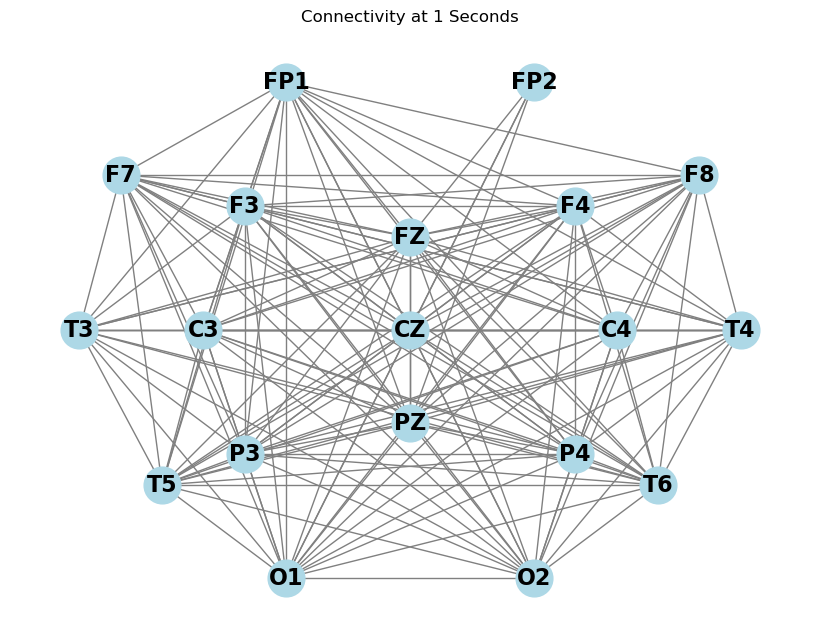

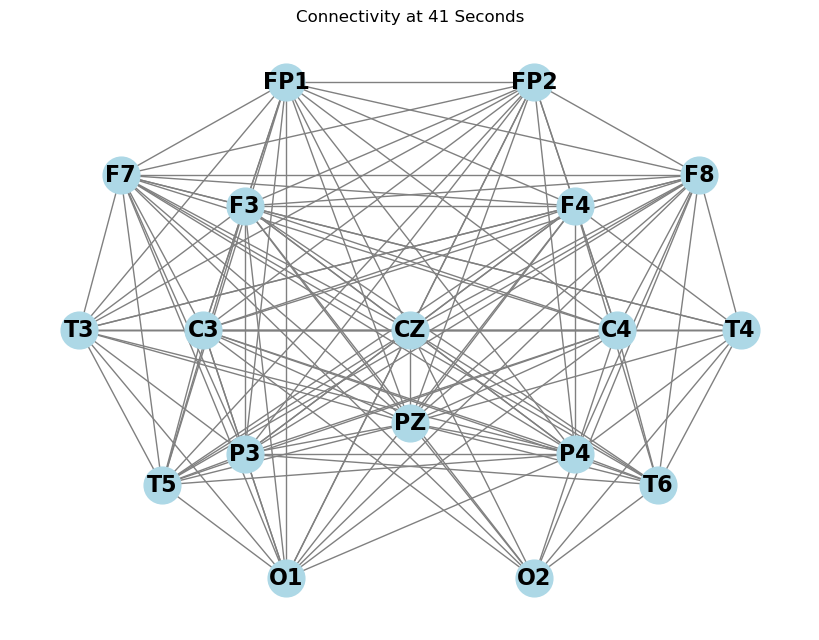

In [141]:
# Original electrode names
electrode_names = [
    'EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF',
    'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF',
    'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF'
]
cleaned_electrode_names = [name.replace('EEG ', '').replace('-REF', '') for name in electrode_names]
# Simplified electrode names
simplified_names = [
    'FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4',
    'T5', 'T6', 'FZ', 'CZ', 'PZ'
]
pos = {'FP1': (-0.3, 0.8),
 'FP2': (0.3, 0.8),
 'F3': (-0.4, 0.4),
 'F4': (0.4, 0.4),
 'C3': (-0.5, 0.0),
 'C4': (0.5, 0.0),
 'P3': (-0.4, -0.4),
 'P4': (0.4, -0.4),
 'O1': (-0.3, -0.8),
 'O2': (0.3, -0.8),
 'F7': (-0.7, 0.5),
 'F8': (0.7, 0.5),
 'T3': (-0.8, 0),
 'T4': (0.8, 0),
 'T5': (-0.6, -0.5),
 'T6': (0.6, -0.5),
 'FZ': (0.0, 0.3),
 'CZ': (0.0, 0.0),
 'PZ': (0.0, -0.3)}

# Create the mapping dictionary
label_mapping = dict(zip(electrode_names, simplified_names))

# Function to relabel nodes
def relabel_nodes(G, mapping):
    return nx.relabel_nodes(G, mapping, copy=True)

# Plot graphs
for i in range(0, 44, 40):  # Indexes for the first and third graphs
    G = graphs_back_bi[i]
    # Relabel the nodes in the graph
    G = relabel_nodes(G, label_mapping)
    weights = nx.get_edge_attributes(G, 'weight')

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=16, font_weight='bold', edge_color='gray')
    plt.title(f'Connectivity at {i+1} Seconds')
    plt.show()

[{'density': 0.7254901960784313}, {'density': 0.40522875816993464}, {'density': 0.52046783625731}, {'density': 0.47953216374269003}, {'density': 1.0}, {'density': 0.5228758169934641}, {'density': 0.9411764705882353}, {'density': 0.39766081871345027}, {'density': 0.7192982456140351}, {'density': 0.738562091503268}, {'density': 0.783625730994152}, {'density': 0.45614035087719296}, {'density': 0.5380116959064327}, {'density': 0.30994152046783624}, {'density': 0.47368421052631576}, {'density': 0.6601307189542484}, {'density': 0.8830409356725146}, {'density': 0.5730994152046783}, {'density': 0.4853801169590643}, {'density': 0.8245614035087719}, {'density': 0.9005847953216374}, {'density': 0.9473684210526315}, {'density': 0.4093567251461988}, {'density': 0.34502923976608185}, {'density': 0.8011695906432749}, {'density': 0.7602339181286549}, {'density': 0.9298245614035088}, {'density': 1.0}, {'density': 1.0}, {'density': 0.954248366013072}, {'density': 1.0}, {'density': 0.7076023391812866}, {

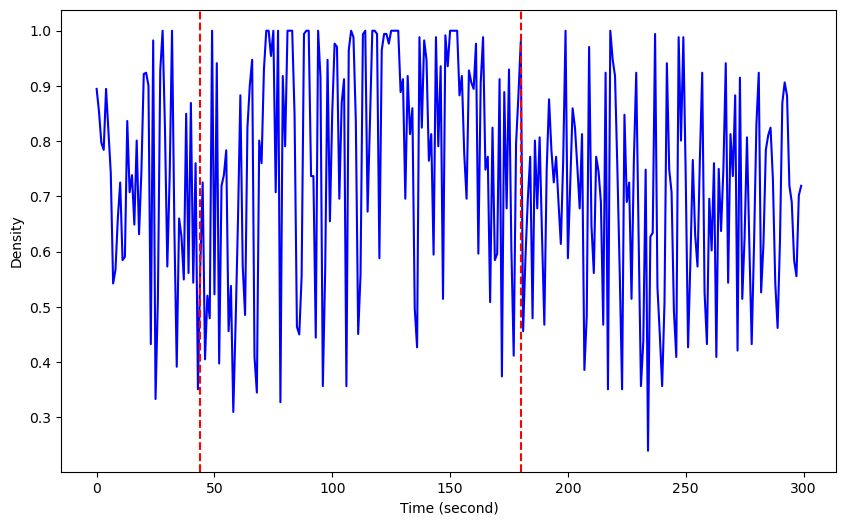

In [142]:
def feature_extract_bi(graph):
    features = {}
    
    features['density'] = nx.density(graph)
    # features['clustering_coefficient'] = nx.average_clustering(graph)
        # Calculate clustering coefficient with error handling
        
    return features

features_seizure_bi = [feature_extract_bi(G) for G in graphs_seiz_bi]
print(features_seizure_bi)

features_background_bi = [feature_extract_bi(G) for G in graphs_back_bi]
print(features_background_bi)

# Initialize lists to collect each feature
density_seizure_list = []

# Collect each feature into lists
for features in features_seizure_bi:
    density_seizure_list.append(features['density'])

# Convert lists to numpy arrays for easier computation
density_seizure_array = np.array(density_seizure_list)

# Calculate mean and standard deviation for each feature
mean_density_seizure = np.mean(density_seizure_array)
std_density_seizure = np.std(density_seizure_array)

# Print results
print(f"Density Seizure: Mean = {mean_density_seizure}, Standard Deviation = {std_density_seizure}")

# Initialize lists to collect each feature
density_background_list = []

# Collect each feature into lists
for features in features_background_bi:
    density_background_list.append(features['density'])

# Convert lists to numpy arrays for easier computation
density_background_array = np.array(density_background_list)

# Calculate mean and standard deviation for each feature
mean_density_background = np.mean(density_background_array)
std_density_background = np.std(density_background_array)

# Print results
print(f"Density Background: Mean = {mean_density_background}, Standard Deviation = {std_density_background}")

# Concatenate the segments
density_combined = np.concatenate((density_background_array[:background_end_1+1], density_seizure_array, density_background_array[background_end_1+2:]))

length = len(density_combined)
x_values = list(range(0, length, 1))
plt.figure(figsize=(10, 6))
plt.plot(x_values[:length], density_combined, color='blue')
plt.axvline(x=seizure_start-1, color='red', linestyle='--', label='Seizure Start')  # Adjusted for the new x-values
plt.axvline(x=seizure_end-1, color='red', linestyle='--', label='Seizure End')    # Adjusted for the new x-values
plt.xlabel('Time (second)')
plt.ylabel('Density')
# plt.title('Graph Densities (Background + Seizure)')
# plt.legend()
plt.show()

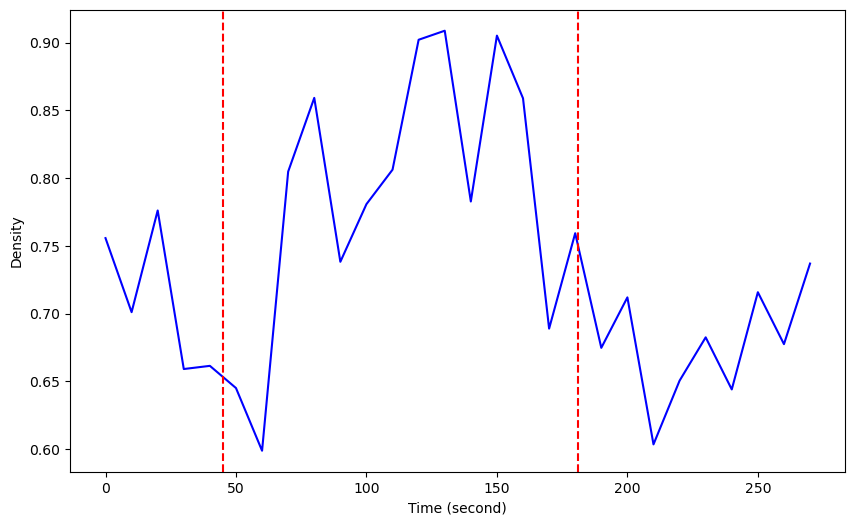

In [143]:
reshaped_array = density_background_array[:len(density_background_array)//10*10].reshape(-1, 10)
averaged_density_background_array = reshaped_array.mean(axis=1)

reshaped_array = density_seizure_array[:len(density_seizure_array)//10*10].reshape(-1, 10)
averaged_density_seizure_array = reshaped_array.mean(axis=1)

# Concatenate the segments
density_combined = np.concatenate((averaged_density_background_array[:background_end_1//10+1], averaged_density_seizure_array, averaged_density_background_array[background_end_1//10+2:]))

plt.close('all')
length = len(density_combined)
x_values = list(range(0, length*10, 10))
plt.figure(figsize=(10, 6))
plt.plot(x_values, density_combined, color='blue')
plt.axvline(x=seizure_start, color='red', linestyle='--', label='Seizure Start')  # Adjusted for the new x-values
plt.axvline(x=seizure_end, color='red', linestyle='--', label='Seizure End')    # Adjusted for the new x-values
plt.xlabel('Time (second)')
plt.ylabel('Density')
plt.show()

In [144]:
def feature_extract(graph):
    features = {}

    # Calculate graph density
    features['density'] = nx.density(graph)

    # Average Clustering Coefficient
    features['avg_clustering'] = nx.average_clustering(graph)

    # Modularity requires community detection, using the 'community' package from 'python-louvain'
    # You may need to install it using: pip install python-louvain
    from community import community_louvain
    # Find communities using the Louvain method
    partition = community_louvain.best_partition(graph)
    features['modularity'] = community_louvain.modularity(partition, graph)

    # Assortativity (Degree Assortativity Coefficient)
    features['assortativity'] = nx.degree_assortativity_coefficient(graph)
    
    return features


def feature_extract_w(graph):
    features_w = {}

    # features_w['characteristic_path_length'] = nx.average_shortest_path_length(graph, weight='weight')
        # Create a new graph with inverted weights
    inverted_graph = nx.Graph()
    for u, v, d in graph.edges(data=True):
        if d['weight'] != 0:  # Ensure the weight is non-zero to avoid division by zero
            inverted_graph.add_edge(u, v, weight=1.0 / d['weight'])

    # Calculate the characteristic path length using the inverted weights
    features_w['characteristic_path_length'] = nx.average_shortest_path_length(inverted_graph, weight='weight')
    
    return features_w

features_seizure = [feature_extract(G) for G in graphs_seiz_bi]
print(features_seizure)

features_background = [feature_extract(G) for G in graphs_back_bi]
print(features_background)

features_seizure_w = [feature_extract_w(G) for G in graphs_seiz]
print(features_seizure_w)

features_background_w = [feature_extract_w(G) for G in graphs_back]
print(features_background_w)

# Initialize lists to collect each feature
density_seizure_list = []
# Initialize lists to collect each feature
clustcoef_seizure_list = []
# Initialize lists to collect each feature
modularity_seizure_list = []
# Initialize lists to collect each feature
assort_seizure_list = []
# Initialize lists to collect each feature
path_seizure_list = []
# Collect each feature into lists
for features in features_seizure:
    density_seizure_list.append(features['density'])
    clustcoef_seizure_list.append(features['avg_clustering'])
    modularity_seizure_list.append(features['modularity'])
    assort_seizure_list.append(features['assortativity'])
for features in features_seizure_w:
    path_seizure_list.append(features['characteristic_path_length'])

# Initialize lists to collect each feature
density_background_list = []
# Initialize lists to collect each feature
clustcoef_background_list = []
# Initialize lists to collect each feature
modularity_background_list = []
# Initialize lists to collect each feature
assort_background_list = []
# Initialize lists to collect each feature
path_background_list = []
# Collect each feature into lists
for features in features_background:
    density_background_list.append(features['density'])
    clustcoef_background_list.append(features['avg_clustering'])
    modularity_background_list.append(features['modularity'])
    assort_background_list.append(features['assortativity'])
for features in features_background_w:
    path_background_list.append(features['characteristic_path_length'])

# Convert lists to numpy arrays for easier computation
density_seizure_array = np.array(density_seizure_list)
# Calculate mean and standard deviation for each feature
mean_density_seizure = np.mean(density_seizure_array)
std_density_seizure = np.std(density_seizure_array)
# Print results
print(f"Density Seizure: Mean = {mean_density_seizure}, Standard Deviation = {std_density_seizure}")

# Convert lists to numpy arrays for easier computation
density_background_array = np.array(density_background_list)
# Calculate mean and standard deviation for each feature
mean_density_background = np.mean(density_background_array)
std_density_background = np.std(density_background_array)
# Print results
print(f"Density Background: Mean = {mean_density_background}, Standard Deviation = {std_density_background}")

# Convert lists to numpy arrays for easier computation - Clustcoef
clustcoef_seizure_array = np.array(clustcoef_seizure_list)
# Calculate mean and standard deviation for each feature
mean_clustcoef_seizure = np.mean(clustcoef_seizure_array)
std_clustcoef_seizure = np.std(clustcoef_seizure_array)
# Print results
print(f"Clustcoef Seizure: Mean = {mean_clustcoef_seizure}, Standard Deviation = {std_clustcoef_seizure}")

clustcoef_background_array = np.array(clustcoef_background_list)
mean_clustcoef_background = np.mean(clustcoef_background_array)
std_clustcoef_background = np.std(clustcoef_background_array)
print(f"Clustcoef Background: Mean = {mean_clustcoef_background}, Standard Deviation = {std_clustcoef_background}")

# Convert lists to numpy arrays for easier computation - Modularity
modularity_seizure_array = np.array(modularity_seizure_list)
mean_modularity_seizure = np.mean(modularity_seizure_array)
std_modularity_seizure = np.std(modularity_seizure_array)
print(f"Modularity Seizure: Mean = {mean_modularity_seizure}, Standard Deviation = {std_modularity_seizure}")

modularity_background_array = np.array(modularity_background_list)
mean_modularity_background = np.mean(modularity_background_array)
std_modularity_background = np.std(modularity_background_array)
print(f"Modularity Background: Mean = {mean_modularity_background}, Standard Deviation = {std_modularity_background}")

# Convert lists to numpy arrays for easier computation - Assortativity
assort_seizure_array = np.array(assort_seizure_list)
mean_assort_seizure = np.mean(assort_seizure_array)
std_assort_seizure = np.std(assort_seizure_array)
print(f"Assortativity Seizure: Mean = {mean_assort_seizure}, Standard Deviation = {std_assort_seizure}")

assort_background_array = np.array(assort_background_list)
mean_assort_background = np.mean(assort_background_array)
std_assort_background = np.std(assort_background_array)
print(f"Assortativity Background: Mean = {mean_assort_background}, Standard Deviation = {std_assort_background}")

# Convert lists to numpy arrays for easier computation - Path Length
path_seizure_array = np.array(path_seizure_list)
mean_path_seizure = np.mean(path_seizure_array)
std_path_seizure = np.std(path_seizure_array)
print(f"Path Length Seizure: Mean = {mean_path_seizure}, Standard Deviation = {std_path_seizure}")

path_background_array = np.array(path_background_list)
mean_path_background = np.mean(path_background_array)
std_path_background = np.std(path_background_array)
print(f"Path Length Background: Mean = {mean_path_background}, Standard Deviation = {std_path_background}")

c:\Users\Atena\anaconda3\envs\eegnetmibci\lib\site-packages\networkx\algorithms\assortativity\correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


[{'density': 0.7254901960784313, 'avg_clustering': 0.8612040737040738, 'modularity': 0.10709358006655309, 'assortativity': 0.041120070606170664}, {'density': 0.40522875816993464, 'avg_clustering': 0.7122574955908291, 'modularity': 0.3350676378772113, 'assortativity': 0.2795826416884058}, {'density': 0.52046783625731, 'avg_clustering': 0.7010559615822775, 'modularity': 0.11791440474687538, 'assortativity': 0.3375051124744382}, {'density': 0.47953216374269003, 'avg_clustering': 0.7437241121451648, 'modularity': 0.2244943486020226, 'assortativity': 0.1749773727083304}, {'density': 1.0, 'avg_clustering': 1.0, 'modularity': 0.0, 'assortativity': nan}, {'density': 0.5228758169934641, 'avg_clustering': 0.7953725287058622, 'modularity': 0.2586718750000001, 'assortativity': 0.08655616942909466}, {'density': 0.9411764705882353, 'avg_clustering': 0.9596366324307498, 'modularity': 0.0, 'assortativity': -0.152727272727264}, {'density': 0.39766081871345027, 'avg_clustering': 0.639857218804587, 'modu

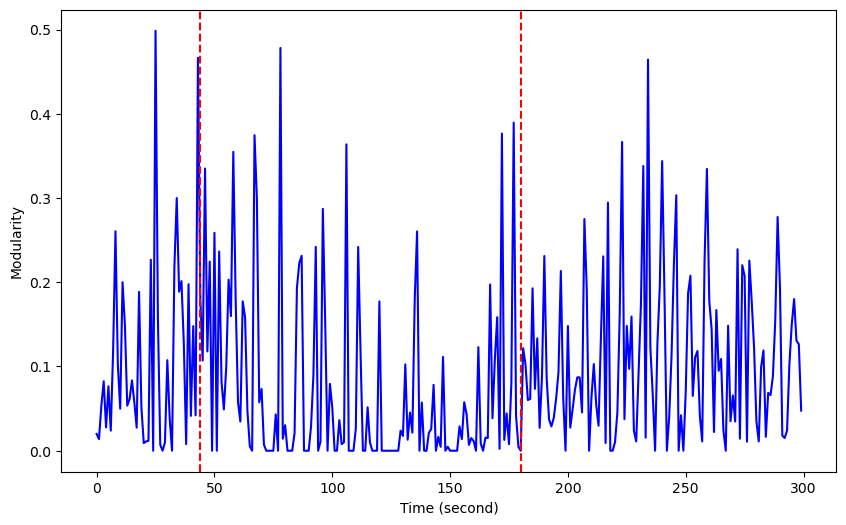

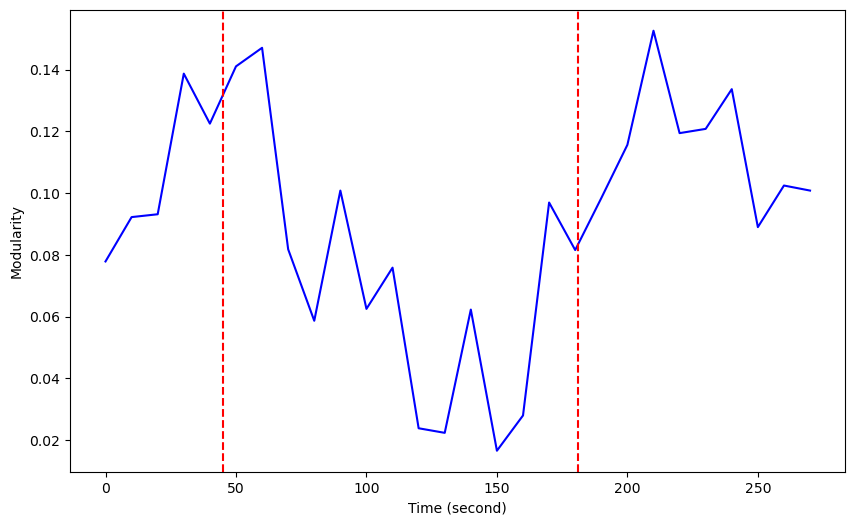

In [145]:
# Concatenate the segments
modularity_combined = np.concatenate((modularity_background_array[:background_end_1+1], modularity_seizure_array, modularity_background_array[background_end_1+2:]))

length = len(modularity_combined)
x_values = list(range(0, length, 1))
plt.figure(figsize=(10, 6))
plt.plot(x_values[:length], modularity_combined, color='blue')
plt.axvline(x=seizure_start-1, color='red', linestyle='--', label='Seizure Start')  # Adjusted for the new x-values
plt.axvline(x=seizure_end-1, color='red', linestyle='--', label='Seizure End')    # Adjusted for the new x-values
plt.xlabel('Time (second)')
plt.ylabel('Modularity')
plt.show()

reshaped_array = modularity_background_array[:len(modularity_background_array)//10*10].reshape(-1, 10)
averaged_modularity_background_array = reshaped_array.mean(axis=1)

reshaped_array = modularity_seizure_array[:len(modularity_seizure_array)//10*10].reshape(-1, 10)
averaged_modularity_seizure_array = reshaped_array.mean(axis=1)

# Concatenate the segments
modularity_combined2 = np.concatenate((averaged_modularity_background_array[:background_end_1//10+1], averaged_modularity_seizure_array, averaged_modularity_background_array[background_end_1//10+2:]))

plt.close('all')
length = len(modularity_combined2)
x_values = list(range(0, length*10, 10))
plt.figure(figsize=(10, 6))
plt.plot(x_values, modularity_combined2, color='blue')
plt.axvline(x=seizure_start, color='red', linestyle='--', label='Seizure Start')  # Adjusted for the new x-values
plt.axvline(x=seizure_end, color='red', linestyle='--', label='Seizure End')    # Adjusted for the new x-values
plt.xlabel('Time (second)')
plt.ylabel('Modularity')
plt.show()

In [146]:
reshaped_array.shape

(13, 10)

In [147]:
assort_seizure_array

array([ 4.11200706e-02,  2.79582642e-01,  3.37505112e-01,  1.74977373e-01,
                   nan,  8.65561694e-02, -1.52727273e-01,  3.83064516e-01,
        7.10995674e-03,  8.98763511e-02, -2.62351252e-02,  5.38567778e-01,
        4.03227809e-01,  6.23350254e-01,  4.23698384e-01,  6.66881343e-01,
       -1.69030160e-01,  1.08325645e-01,  3.85079800e-01, -6.14464793e-02,
       -1.16841257e-01, -2.07281316e-01,  4.64525547e-01,  9.81909645e-02,
       -1.12067532e-02, -1.16476429e-01, -1.29816890e-01,             nan,
                   nan, -1.46221786e-01,             nan,  2.46105919e-01,
                   nan,  7.00342721e-03, -1.59888696e-01,  3.61266909e-01,
                   nan,             nan,             nan, -5.27462156e-02,
        4.94686783e-01,  7.87662503e-01,  1.11731317e-01, -1.11111111e-01,
                   nan,             nan,  1.56345402e-01,  3.65216097e-02,
        6.31351455e-01,             nan, -1.32947977e-01,  4.90018768e-01,
        1.38910790e-01, -

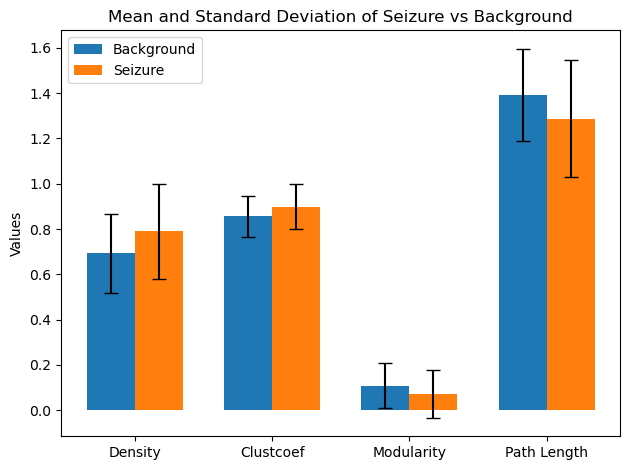

In [148]:
# Data for plotting
categories = ['Density', 'Clustcoef', 'Modularity', 'Path Length']
mean_seizure = [mean_density_seizure, mean_clustcoef_seizure, mean_modularity_seizure, mean_path_seizure]
std_seizure = [std_density_seizure, std_clustcoef_seizure, std_modularity_seizure, std_path_seizure]
mean_background = [mean_density_background, mean_clustcoef_background, mean_modularity_background, mean_path_background]
std_background = [std_density_background, std_clustcoef_background, std_modularity_background, std_path_background]

# Create bar plot
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
# bars_seizure = ax.bar(x - width/2, mean_seizure, width, yerr=std_seizure, label='Seizure', capsize=5)
# bars_background = ax.bar(x + width/2, mean_background, width, yerr=std_background, label='Background', capsize=5)
bars_background = ax.bar(x - width/2, mean_background, width, yerr=std_background, label='Background', capsize=5)
bars_seizure = ax.bar(x + width/2, mean_seizure, width, yerr=std_seizure, label='Seizure', capsize=5)

# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('Values')
ax.set_title('Mean and Standard Deviation of Seizure vs Background')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [154]:
window_size = 20
# Calculate the mean of all values
mean_density_value_seizure = np.array([np.mean(density_seizure_array[i:i + window_size]) for i in range(len(density_seizure_array) - window_size + 1)])
# Calculate the standard deviation of all values
std_density_value_seizure = np.array([np.std(density_seizure_array[i:i + window_size]) for i in range(len(density_seizure_array) - window_size + 1)])
mean_density_seizure = np.mean(mean_density_value_seizure)
std_density_seizure = np.mean(std_density_value_seizure)
print(f"Mean: {mean_density_seizure}")
print(f"Standard Deviation: {std_density_seizure}")

# Calculate the mean of all values 
mean_density_value_background = np.array([np.mean(density_background_array[i:i + window_size]) for i in range(len(density_background_array) - window_size + 1)])
# Calculate the standard deviation of all values
std_density_value_background = np.array([np.std(density_background_array[i:i + window_size]) for i in range(len(density_background_array) - window_size + 1)])
mean_density_background = np.mean(mean_density_value_background)
std_density_background = np.mean(std_density_value_background)
print(f"Mean: {mean_density_background}")
print(f"Standard Deviation: {std_density_background}")


Mean: 0.8075362593680446
Standard Deviation: 0.18966476940558308
Mean: 0.6884763278058159
Standard Deviation: 0.1740924170733777


In [ ]:
#  Extract signal data
data, times = eegICA[:]
data = data[:19, :]
n_channels, n_samples = data.shape

# # Perform FFT on each channel and calculate the power spectrum
# power_spectra = np.zeros((n_channels, n_samples // 2 + 1))

# for i in range(n_channels):
#     signal = data[i, :]
#     fft_coefficients = np.fft.rfft(signal)
#     power_spectra[i, :] = np.abs(fft_coefficients) ** 2

# # Average the power spectrum over all channels
# average_power_spectrum = np.mean(power_spectra, axis=0)

# # Frequencies corresponding to the power spectrum
# frequencies = np.fft.rfftfreq(n_samples, d=1 / sampfreq)

# plt.close('all')
# # Plot the average power spectrum over time
# plt.figure(figsize=(12, 8))
# plt.plot(frequencies, average_power_spectrum)
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power')
# plt.title('Average Power Spectrum Over All Channels')
# plt.show()

# from scipy.signal import stft

# # Parameters for STFT
# window = 'hann'  # Type of window (Hanning window)
# nperseg = 256    # Length of each segment for STFT (adjust based on data resolution)
# noverlap = nperseg // 2  # Overlap between segments

# # Compute STFT for each channel and average power across channels
# average_power_time = np.zeros((n_channels, n_samples//noverlap+1))

# for i in range(n_channels):
#     signal = data[i, :]
#     # Perform STFT
#     f, t, Zxx = stft(signal, fs=sampfreq, window=window, nperseg=nperseg, noverlap=noverlap)
#     # Calculate power (magnitude squared of STFT coefficients)
#     power = np.abs(Zxx) ** 2
#     # Sum power over frequency to get power over time
#     average_power_time[i, :] = np.mean(power, axis=0)

# # Average power over all channels
# average_power_over_time = np.mean(average_power_time, axis=0)

# # Plot power at each time point
# plt.figure(figsize=(12, 8))
# plt.plot(t, average_power_over_time)
# plt.xlabel('Time (s)')
# plt.ylabel('Average Power')
# plt.title('Average Power Over Time Across All Channels')
# plt.show()

# Sampling rate of the data
sampling_rate = raw.info['sfreq']

# Calculate the energy of the signal for each channel
energy = np.zeros((n_channels, n_samples))

for i in range(n_channels):
    signal = data[i, :]
    energy[i, :] = signal ** 2

# Average the energy over all channels
average_energy = np.mean(energy, axis=0)

# Plot the average energy over time
plt.figure(figsize=(12, 8))
plt.plot(times, average_energy)
plt.axvline(x=44, color='red', linestyle='--', label='Seizure Start')  # Adjusted for the new x-values
plt.axvline(x=181, color='red', linestyle='--', label='Seizure End')    # Adjusted for the new x-values
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.title('Average Energy Over Time (All Channels)')
plt.show()

# # Select average energy values every 512 samples
# segment_size = 256  # Number of samples per segment
# average_energy_segments = average_energy[::segment_size]
# segment_times = times[::segment_size] + (segment_size / 2) / sampling_rate

# # Plot the average energy over time (every 512 samples)
# plt.figure(figsize=(12, 8))
# plt.plot(segment_times, average_energy_segments)
# plt.axvline(x=44, color='red', linestyle='--', label='Seizure Start')  # Adjusted for the new x-values
# plt.axvline(x=181, color='red', linestyle='--', label='Seizure End')    # Adjusted for the new x-values
# plt.xlabel('Time (s)')
# plt.ylabel('Energy')
# plt.title('Average Energy Over Time (All Channels)')
# plt.show()